# PreProcessing, EDA and Feature extraction notebook

## Importing libraries and packages installation

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import os
import json
import re
import string
from tqdm import tqdm
import sys
import subprocess
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
import scipy.sparse as sp
from datasets import load_dataset
import unicodedata
import contractions
from scipy.stats import pearsonr

c:\Users\Rafa Parkoureiro\anaconda3\envs\NLP\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Check and install required packages
def install_package(package):
    print(f"Installing {package}...")
    subprocess.check_call([sys.executable, "-m", "pip", "install", package])

In [ ]:
# Install transformers for BERT if necessary
try:
    import torch
except ImportError:
    print("Installing required packages for BERT...")
    install_package("torch")
    install_package("transformers")
    import torch

In [5]:
# Check GPU availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cpu


In [6]:
# Load dataset and apply preprocessing
print("Loading dataset...")
df = load_dataset("ayjays132/Emotionverse")
df = pd.DataFrame(df['train'])

Loading dataset...


In [7]:
# Download necessary NLTK resources
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('vader_lexicon')

[nltk_data] Downloading package stopwords to C:\Users\Rafa
[nltk_data]     Parkoureiro\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\Rafa
[nltk_data]     Parkoureiro\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to C:\Users\Rafa
[nltk_data]     Parkoureiro\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package vader_lexicon to C:\Users\Rafa
[nltk_data]     Parkoureiro\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [8]:
# Initialize NLTK resources
stop_words = set(stopwords.words('english')) - {"no", "not", "nor","never"}
lemmatizer = WordNetLemmatizer()

## PreProcessing

In [9]:
# Preprocessing functions
def normalize_unicode(text):
    return unicodedata.normalize("NFKD", text)

def clean_text(text):
    text = normalize_unicode(text)
    #text = contractions.fix(text)  # Expand contractions: I'm → I am
    text = re.sub(r"http\S+|www\S+", "", text)  # Remove URLs
    text = re.sub(r"@\w+", "", text)  # Remove mentions
    text = re.sub(r"#", "", text)  # Remove hashtag symbols (keep word)
    text = re.sub(r"[^\w\s!?',.]", " ", text)  # Keep ! ? ' , . for emotion and sentence structure
    return text

def to_lowercase(text):
    return text.lower()

def handle_negation(tokens):
    """
    Modify tokens following negation words to capture sentiment impact,
    with continued negation tracking across punctuation.
    
    Parameters:
    -----------
    tokens : list
        List of tokens in a sentence
    
    Returns:
    --------
    list
        Tokens with negation handling applied
    """
    # Negation words that trigger modification
    negation_words = {'not', 'no', 'never', 'neither', 'hardly', 'scarcely'}
    
    # Punctuation that might interrupt token processing
    stop_punctuation = {',', '.', '!', '?'}
    
    modified_tokens = []
    is_negated = False
    i = 0
    
    while i < len(tokens):
        # Check if current token is a negation word
        if tokens[i].lower() in negation_words:
            # Toggle negation state
            is_negated = not is_negated
            modified_tokens.append(tokens[i])
        
        # Apply negation prefix if currently in negated state
        elif is_negated:
            # Check if token is punctuation
            if tokens[i] in stop_punctuation:
                # If punctuation, reset negation state
                is_negated = False
                modified_tokens.append(tokens[i])
            else:
                # Prefix token with NOT_
                modified_tokens.append(f'NOT_{tokens[i]}')
        
        # Normal token processing when not negated
        else:
            modified_tokens.append(tokens[i])
        
        # Move to next token
        i += 1
    
    return modified_tokens


In [10]:
def preprocess_text_pipeline(text):
    # Apply string-based cleaning first
    text = clean_text(text)
    text = to_lowercase(text)
    # Then tokenize
    tokens = word_tokenize(text)
    
    # Process tokens
    tokens = [token for token in tokens if token not in stop_words]
    tokens = [lemmatizer.lemmatize(token) for token in tokens]
    tokens = handle_negation(tokens)
    tokens = [token for token in tokens if token not in (",",".")]

    # Join back to string
    return " ".join(tokens)

In [11]:
# Apply preprocessing
print("Applying preprocessing...")
df['clean_text'] = df['text'].apply(preprocess_text_pipeline)
print(f"Total of {len(df)} documents processed")

Applying preprocessing...
Total of 1874 documents processed


## EDA

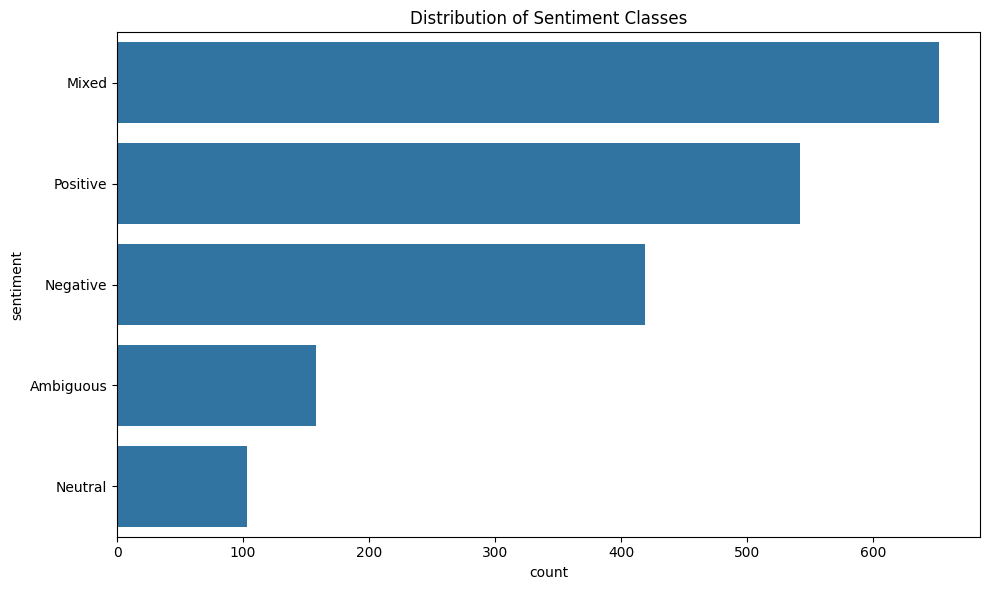

In [12]:
# Visualize sentiment distribution
plt.figure(figsize=(10, 6))
sns.countplot(y='sentiment', data=df, order=df['sentiment'].value_counts().index)
plt.title('Distribution of Sentiment Classes')
plt.tight_layout()
plt.show()

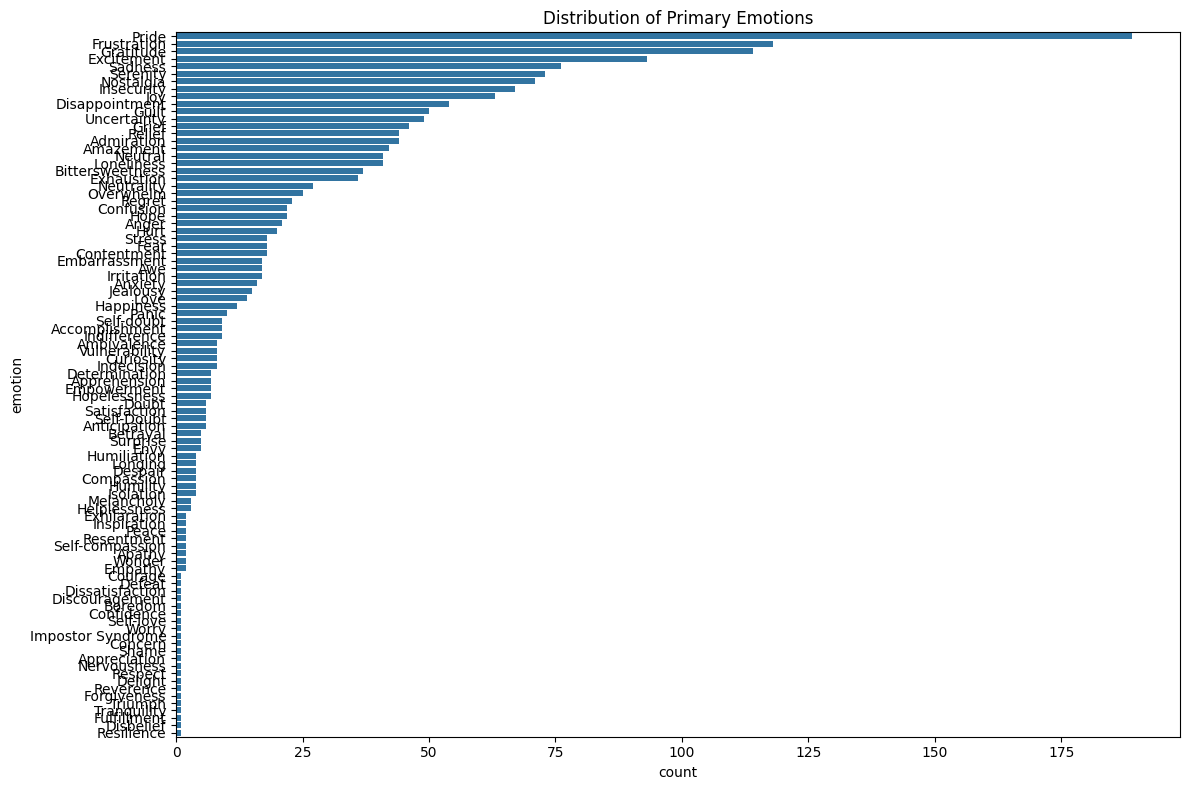

In [13]:
# Visualize primary emotions
plt.figure(figsize=(12, 8))
emotion_counts = Counter(df['primary_emotion'])
emotion_df = pd.DataFrame({'emotion': list(emotion_counts.keys()), 
                           'count': list(emotion_counts.values())})
emotion_df = emotion_df.sort_values('count', ascending=False)
sns.barplot(x='count', y='emotion', data=emotion_df)
plt.title('Distribution of Primary Emotions')
plt.tight_layout()
plt.show()

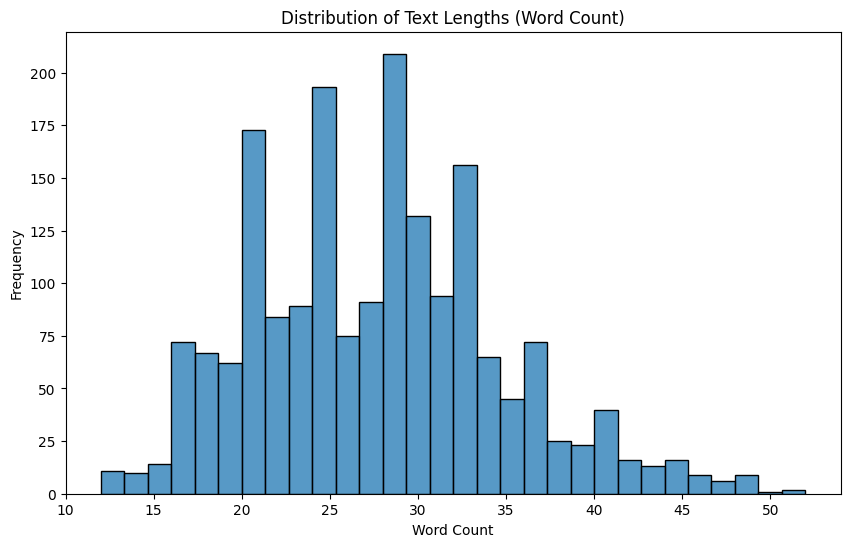

In [14]:
# Text length distribution
plt.figure(figsize=(10, 6))
text_lengths = [len(text.split()) for text in df['text']]
sns.histplot(text_lengths, bins=30)
plt.title('Distribution of Text Lengths (Word Count)')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.show()


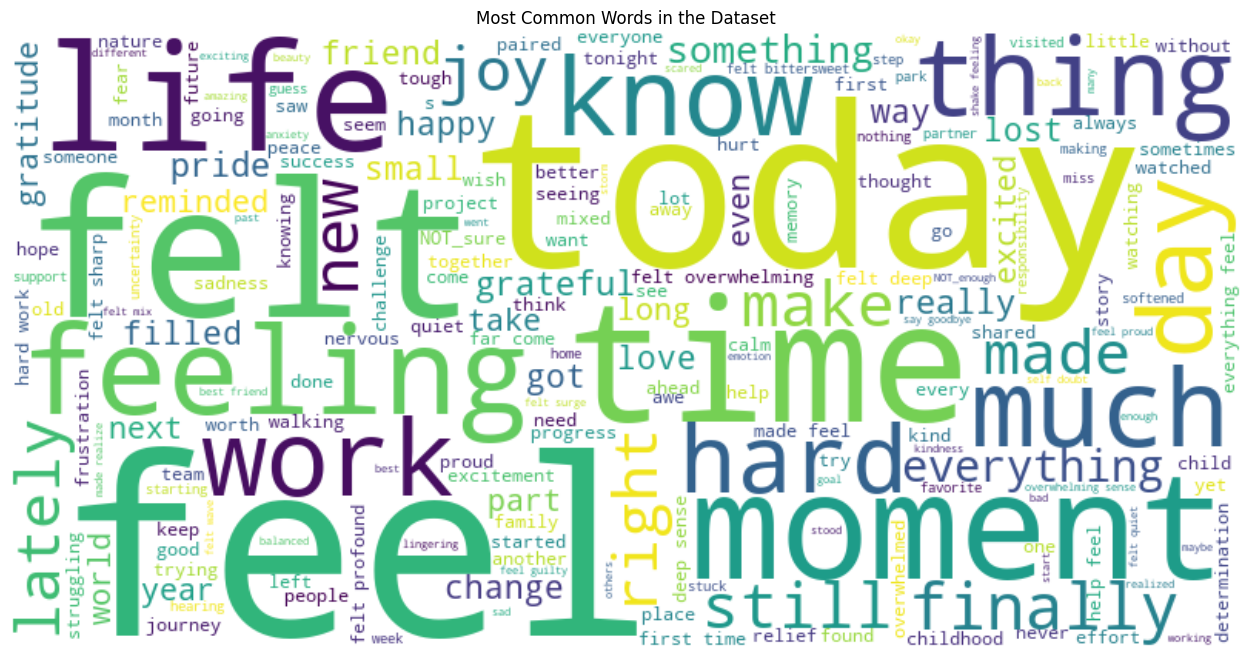

In [15]:
# Word cloud for visualizing common terms
all_text = ' '.join(df['clean_text'].tolist())
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_text)
plt.figure(figsize=(16, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Most Common Words in the Dataset')
plt.show()


In [16]:
df.to_csv('clean.csv')

df["clean_text"]

0       proud friend overcoming struggle make wonder e...
1       finally finished project ! exhausting thrilled...
2       laughter shared reunion best part week miss mo...
3          everything feel uncertain right ? wish clarity
4       graduation feel exciting sad end something bea...
                              ...                        
1869    feel like lost sight truly matter need take st...
1870    excited see family long way long since got tog...
1871      shake nagging feeling not NOT_enough exhausting
1872    love rainy day give chance relax reflect every...
1873    feeling little stuck lately like rut hard brea...
Name: clean_text, Length: 1874, dtype: object

## Feature Extraction

In [17]:
# Create directory to save features
output_dir = 'emotionverse_features_advanced'
os.makedirs(output_dir, exist_ok=True)

In [18]:
# Function to save labels and IDs for later use
def save_labels_and_ids(df, output_file='emotionverse_labels.csv'):
    labels_df = df[['sentiment', 'primary_emotion']].copy()
    labels_df['id'] = list(range(len(df)))  # Add ID column
    labels_df.to_csv(output_file, index=False)
    print(f"Labels saved to {output_file}")
    return labels_df

In [19]:
# 1. Bag of Words (BoW)
def extract_and_save_bow(df, max_features=5000, ngram_range=(1, 1), output_file='bow_features.npz'):
    print("Extracting Bag of Words features...")
    vectorizer = CountVectorizer(max_features=max_features, ngram_range=ngram_range)
    X_bow = vectorizer.fit_transform(df['clean_text'])
    
    # Save sparse matrix
    sp.save_npz(output_file, X_bow)
    
    # Save feature names and vocabulary for reference
    feature_names = vectorizer.get_feature_names_out()
    vocab = vectorizer.vocabulary_
    with open(output_file.replace('.npz', '_metadata.json'), 'w') as f:
        json.dump({
            'feature_names': feature_names.tolist(),
            'vocab_size': len(feature_names),
            'shape': X_bow.shape,
            'ngram_range': ngram_range,
            'max_features': max_features
        }, f)

    print(f"BoW Dimensions: {X_bow.shape}")
    print(f"Feature space size: {len(feature_names)}")
    print(f"Saved to {output_file} and {output_file.replace('.npz', '_metadata.json')}")
    return X_bow, vectorizer

In [20]:
# 2. TF-IDF
def extract_and_save_tfidf(df, max_features=5000, ngram_range=(1, 1), output_file='tfidf_features.npz'):
    print("Extracting TF-IDF features...")
    vectorizer = TfidfVectorizer(max_features=max_features, ngram_range=ngram_range)
    X_tfidf = vectorizer.fit_transform(df['clean_text'])
    
    # Save sparse matrix
    sp.save_npz(output_file, X_tfidf)
    
    # Save feature names and vocabulary for reference
    feature_names = vectorizer.get_feature_names_out()
    vocab = vectorizer.vocabulary_
    with open(output_file.replace('.npz', '_metadata.json'), 'w') as f:
        json.dump({
            'feature_names': feature_names.tolist(),
            'vocab_size': len(feature_names),
            'shape': X_tfidf.shape,
            'ngram_range': ngram_range,
            'max_features': max_features
        }, f)
    
    print(f"TF-IDF Dimensions: {X_tfidf.shape}")
    print(f"Feature space size: {len(feature_names)}")
    print(f"Saved to {output_file} and {output_file.replace('.npz', '_metadata.json')}")
    return X_tfidf, vectorizer

# New part new lexicons:

In [21]:
#EXTRAVADER
def extract_vader_lexicon_features(df, vectorizer, text_column='clean_text', output_file='vader_lexicon_features.npy'):
    """
    Extract VADER sentiment lexicon features aligned with vocabulary.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        DataFrame containing the text data
    vectorizer : sklearn vectorizer
        Fitted vectorizer (TfidfVectorizer or CountVectorizer)
    text_column : str
        Column name containing the processed text
    output_file : str
        Path to save the numpy array with features
        
    Returns:
    --------
    tuple
        (word_level_features, document_level_features)
    """
    print("Extracting VADER Sentiment Lexicon features...")
    
    # Initialize VADER sentiment analyzer
    sid = SentimentIntensityAnalyzer()
    
    # Get vocabulary from the vectorizer
    feature_names = vectorizer.get_feature_names_out()
    
    # Create lexicon scores for each word in the vocabulary
    lexicon_scores = np.zeros((len(feature_names), 4))  # neg, neu, pos, compound
    
    for i, word in tqdm(enumerate(feature_names), total=len(feature_names), desc="Calculating VADER scores"):
        scores = sid.polarity_scores(word)
        lexicon_scores[i, 0] = scores['neg']
        lexicon_scores[i, 1] = scores['neu']
        lexicon_scores[i, 2] = scores['pos']
        lexicon_scores[i, 3] = scores['compound']
    
    # Save as numpy array
    #np.save(output_file, lexicon_scores)
    
    # Save metadata
    with open(output_file.replace('.npy', '_metadata.json'), 'w') as f:
        json.dump({
            'feature_names': feature_names.tolist(),
            'score_types': ['negative', 'neutral', 'positive', 'compound'],
            'shape': lexicon_scores.shape,
            'lexicon': 'VADER'
        }, f)
    
    print(f"Word-level Lexicon Feature Dimensions: {lexicon_scores.shape}")
    print(f"Saved to {output_file} and {output_file.replace('.npy', '_metadata.json')}")
    
    # Create and save document-level features based on scores
    document_lexicon_features = np.zeros((len(df), 4))
    X = vectorizer.transform(df[text_column])
    
    # For each document, calculate the weighted average of sentiment scores
    for i in tqdm(range(len(df)), desc="Creating document features"):
        # Get indices of non-zero words and their TF-IDF/BoW values
        row = X[i].toarray().flatten()
        nonzero_indices = np.nonzero(row)[0]
        weights = row[nonzero_indices]
        
        # Skip if no terms are found
        if len(nonzero_indices) == 0:
            continue
            
        # Compute weighted average of scores for each sentiment dimension
        weighted_scores = np.zeros(4)
        for j, idx in enumerate(nonzero_indices):
            weighted_scores += weights[j] * lexicon_scores[idx]
            
        # Normalize by the sum of weights
        document_lexicon_features[i] = weighted_scores / weights.sum()
    
    # Save document-level features
    #doc_output_file = output_file.replace('.npy', '_document.npy')
    #np.save(doc_output_file, document_lexicon_features)
    
    
    print(f"Document-level Lexicon Feature Dimensions: {document_lexicon_features.shape}")

    
    return lexicon_scores, document_lexicon_features

In [22]:
# COMBINE FEATURES :

def combine_features(tfidf_features=None, vader_features=None, lexicon_features=None, embedding_features=None, output_file="emotionverse_features_advanced/Combinedfeatures.npy"):
    """
    Combine different feature sets for later use in classification.
    
    Parameters:
    -----------
    tfidf_features : scipy.sparse matrix
        TF-IDF features
    bow_features : scipy.sparse matrix
        Bag of Words features
    vader_features : numpy.ndarray, optional
        VADER sentiment features
    nrc_features : numpy.ndarray, optional
        NRC emotion features
    embedding_features : numpy.ndarray, optional
        Text embedding features
        
    Returns:
    --------
    dict
        Dictionary with feature matrices and metadata
    """
    from scipy.sparse import hstack, csr_matrix
    import scipy.sparse as sp

    features={}
    
    if tfidf_features is not None:
        features['tfidf'] = tfidf_features

    if vader_features is not None:
        features['vader'] = csr_matrix(vader_features)
        
    if lexicon_features is not None:
        features['nrc'] = csr_matrix(lexicon_features)
        
    if embedding_features is not None:
        features['embeddings'] = csr_matrix(embedding_features)
    
    # Create a combined sparse feature matrix
    feature_matrices = [features[key] for key in features]
    combined_features = hstack(feature_matrices)
    
    features['combined'] = combined_features
    
    # Create feature information
    feature_info = {
        'shapes': {k: v.shape for k, v in features.items()},
        'dtypes': {k: str(v.dtype) for k, v in features.items()},
        'sparsity': {k: 1.0 - (v.nnz / (v.shape[0] * v.shape[1])) 
                    if sp.issparse(v) else np.count_nonzero(v) / v.size
                    for k, v in features.items()}
    }
    
    features['info'] = feature_info
    np.save(output_file, features['combined'])
    # Save document-level metadata
    with open(output_file.replace('.npy', '_metadata.json'), 'w') as f:
        json.dump({
            'shapes' : feature_info['shapes'],
            'dtypes' : feature_info['dtypes'],
            'sparsity' : feature_info['sparsity'],
        }, f)




    return features

In [23]:
def extract_and_save_sentiment_embeddings_pro(df, output_file='sentiment_embeddings_pro.npy', 
                                         model_name='all-MiniLM-L6-v2',
                                         text_column='clean_text',
                                         label_column='sentiment',
                                         batch_size=32):
    """
    Extract sentence embeddings optimized for sentiment analysis with 5 labels.
    
    Parameters:
    - df: DataFrame with preprocessed text and sentiment labels
    - output_file: Where to save the embeddings
    - model_name: SentenceTransformer model to use
    - text_column: Column name containing preprocessed text
    - label_column: Column name containing sentiment labels
    - batch_size: Batch size for embedding extraction
    
    Returns:
    - X_embeddings: The extracted embeddings
    - labels: The corresponding sentiment labels
    """
    print(f"Extracting sentiment-optimized embeddings using {model_name}...")
    
    # Verify sentiment labels
    sentiment_labels = df[label_column].unique()
    print(f"Found {len(sentiment_labels)} sentiment classes: {sentiment_labels}")
    
    from sklearn.preprocessing import LabelEncoder

    # Instead of the manual mapping
    label_encoder = LabelEncoder()
    df['label_numeric'] = label_encoder.fit_transform(df[label_column])
    labels = df['label_numeric'].values

    
    # Check for missing values
    if df[text_column].isna().any():
        print(f"Warning: Found {df[text_column].isna().sum()} missing values in '{text_column}'. Filling with empty string.")
        df[text_column] = df[text_column].fillna('')
    
    # Load Sentence-BERT model
    try:
        from sentence_transformers import SentenceTransformer
        import torch
        
        # Determine device
        device = 'cuda' if torch.cuda.is_available() else 'cpu'
        print(f"Using {device} for embedding extraction")
        
        model = SentenceTransformer(model_name)
        model.to(device)
        
        # Extract embeddings for preprocessed text
        X_embeddings = model.encode(
            df[text_column].tolist(),
            batch_size=batch_size,
            show_progress_bar=True,
            device=device,
            convert_to_numpy=True
        )
        
        # Save embeddings and labels
        np.save(output_file, X_embeddings)
        np.save(output_file.replace('.npy', '_labels.npy'), labels)
        
        # Save metadata
        with open(output_file.replace('.npy', '_metadata.json'), 'w') as f:
            import json
            json.dump({
                'model': model_name,
                'embedding_dim': X_embeddings.shape[1],
                'shape': X_embeddings.shape,
                'sentiment_classes': list(sentiment_labels),
            }, f)
        
        print(f"Embedding Dimensions: {X_embeddings.shape}")
        print(f"Saved embeddings to {output_file}")
        print(f"Saved labels to {output_file.replace('.npy', '_labels.npy')}")
        print(f"Saved metadata to {output_file.replace('.npy', '_metadata.json')}")
        
        return X_embeddings, labels
    
    except Exception as e:
        print(f"Error extracting embeddings: {e}")
        raise

In [24]:
# my own lexicon 

import os
import json
import numpy as np
import pandas as pd
from collections import defaultdict
from typing import List, Dict, Any
from tqdm import tqdm

SENTIMENT_LABELS = ['Mixed', 'Negative', 'Positive', 'Neutral', 'Ambiguous']

def create_sentiment_lexicon(texts: List[str], labels: List[str]) -> Dict[str, Any]:
    label_word_freq = {label: defaultdict(int) for label in SENTIMENT_LABELS}
    word_total_freq = defaultdict(int)

    for text, label in zip(texts, labels):
        words = text.lower().split()
        for word in words:
            label_word_freq[label][word] += 1
            word_total_freq[word] += 1

    lexicon = {}
    for word in word_total_freq:
        word_features = {
            'total_freq': word_total_freq[word],
            'label_ratios': {}
        }
        for label in SENTIMENT_LABELS:
            label_freq = label_word_freq[label][word]
            word_features['label_ratios'][label] = (
                label_freq / word_total_freq[word] if word_total_freq[word] > 0 else 0
            )
        lexicon[word] = word_features

    return lexicon

def generate_5d_lexicon_features(
    df: pd.DataFrame,
    text_col: str = 'clean_text',
    label_col: str = 'sentiment',
    output_file: str = 'custom_lexicon_features.npy'
) -> np.ndarray:
    """
    Generate and save 5D lexicon features (one per sentiment class).
    Returns a NumPy array of shape (n_docs, 5).
    """
    print("Creating 5D sentiment lexicon features...")
    lexicon = create_sentiment_lexicon(df[text_col].tolist(), df[label_col].tolist())

    doc_features = np.zeros((len(df), len(SENTIMENT_LABELS)))

    for i, text in tqdm(enumerate(df[text_col]), total=len(df)):
        words = text.lower().split()
        sentiment_sums = np.zeros(len(SENTIMENT_LABELS))
        word_count = 0

        for word in words:
            if word in lexicon:
                for j, label in enumerate(SENTIMENT_LABELS):
                    sentiment_sums[j] += lexicon[word]['label_ratios'][label]
                word_count += 1

        if word_count > 0:
            doc_features[i] = sentiment_sums / word_count
        else:
            doc_features[i] = 0

    print("Lexicon feature shape:", doc_features.shape)

    # Save features
    np.save(output_file, doc_features)

    # Save metadata
    metadata = {
        'features': SENTIMENT_LABELS,
        'shape': doc_features.shape,
        'source': 'custom lexicon based on training data',
        'text_column': text_col,
        'label_column': label_col
    }
    with open(output_file.replace('.npy', '_metadata.json'), 'w') as f:
        json.dump(metadata, f, indent=2)

    print(f"Saved features to {output_file}")
    print(f"Saved metadata to {output_file.replace('.npy', '_metadata.json')}")

    return doc_features

In [25]:
from sklearn.preprocessing import MinMaxScaler, MaxAbsScaler

# Main function to extract all features
def extract_all_advanced_features(df, output_dir='emotionverse_features_advanced'):
    # Create output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)
    
    # Define file paths
    bow_file = os.path.join(output_dir, 'bow_features.npz')
    tfidf_file = os.path.join(output_dir, 'tfidf_features.npz')
    sentence_emb_file = os.path.join(output_dir, 'sentence_embeddings.npy')
    labels_file = os.path.join(output_dir, 'emotionverse_labels.csv')
    tf_lexi =  os.path.join(output_dir, 'tf_lexi.npy')
    tf_vader_file = os.path.join(output_dir, 'tf_vader_file.npy')
    bert_vader_file = os.path.join(output_dir, 'bert_vader_file.npy')
    bert_lexi = os.path.join(output_dir, 'bert_lexi.npy')
    tf_bert_vader_file = os.path.join(output_dir, 'tf_bert_vader_file.npy')
    tf_bert_lexi = os.path.join(output_dir, 'tf_bert_lexi.npy')
    my_lexicon = os.path.join(output_dir, 'custom_lexicon_features.npy')


    # Extract and save features
    print("\n--- Starting advanced feature extraction ---\n")
    
    # 1. Extract BoW
    X_bow, bow_vectorizer = extract_and_save_bow(df, output_file=bow_file)
    
    # 2. Extract TF-IDF
    X_tfidf, tfidf_vectorizer = extract_and_save_tfidf(df, output_file=tfidf_file)

    
    # 7. Extract sentence embeddings with Sentence-BERT

    sentence_pro, _= extract_and_save_sentiment_embeddings_pro(df, output_file= sentence_emb_file)
    
    # 8. Save labels
    labels_df = save_labels_and_ids(df, output_file=labels_file)
    

    _, vader_features = extract_vader_lexicon_features(df, tfidf_vectorizer)

        
    lexicon_feats = generate_5d_lexicon_features(
        df,
        text_col='clean_text',
        label_col='sentiment',
        output_file= my_lexicon
    )
    

    import numpy as np

    bertsentencescaler = MinMaxScaler()
    scaled_bert_sentence = bertsentencescaler.fit_transform(sentence_pro)

    scaler_vader = MinMaxScaler()
    scaled_vader_features = scaler_vader.fit_transform(vader_features)

    scaler_my = MinMaxScaler()
    scaled_my_features = scaler_my.fit_transform(lexicon_feats)

    scaler_tf = MaxAbsScaler()
    scaled_tf = scaler_tf.fit_transform(X_tfidf)

    
    tf_lexicon = combine_features(
        scaled_tf, 
        None,
        scaled_my_features,
        None,
        output_file=tf_lexi
    )

    tf_vader= combine_features(
        scaled_tf, 
        scaled_vader_features,
        None,
        None,
        output_file=tf_vader_file
    )
    bert_vader = combine_features(
        None,
        scaled_vader_features,
        None,
        scaled_bert_sentence,
        output_file= bert_vader_file
    )

    bert_lexicon = combine_features(
        None,
        None,
        scaled_my_features,
        scaled_bert_sentence,
        output_file= bert_lexi
    )

    tf_bert_vader = combine_features(
        scaled_tf,
        scaled_vader_features,
        None,
        scaled_bert_sentence,
        output_file= tf_bert_vader_file
    )
        
    tf_bert_lexicon = combine_features(
        scaled_tf,
        None,
        scaled_my_features,
        scaled_bert_sentence,
        output_file= tf_bert_lexi
    )

    print("\n--- Feature extraction completed! ---")
    print(f"All features saved in {output_dir}/")
    
    return {
        'bow': (X_bow, bow_vectorizer),
        'tfidf': (X_tfidf, tfidf_vectorizer),
        'vader' : vader_features,
        'my_features'  : lexicon_feats,
        'bert' : sentence_pro,
        'tf_lexicon' : tf_lexicon,
        'tf_vader' : tf_vader,
        'bert_vader' : bert_vader,
        'bert_lexicon' : bert_lexicon,
        'tf_bert_vader' : tf_bert_vader,
        'tf_bert_lexicon' : tf_bert_lexicon
    }

In [26]:
features = extract_all_advanced_features(df)


--- Starting advanced feature extraction ---

Extracting Bag of Words features...
BoW Dimensions: (1874, 3269)
Feature space size: 3269
Saved to emotionverse_features_advanced\bow_features.npz and emotionverse_features_advanced\bow_features_metadata.json
Extracting TF-IDF features...
TF-IDF Dimensions: (1874, 3269)
Feature space size: 3269
Saved to emotionverse_features_advanced\tfidf_features.npz and emotionverse_features_advanced\tfidf_features_metadata.json
Extracting sentiment-optimized embeddings using all-MiniLM-L6-v2...
Found 5 sentiment classes: ['Mixed' 'Positive' 'Ambiguous' 'Negative' 'Neutral']
Using cpu for embedding extraction


Batches: 100%|██████████| 59/59 [00:04<00:00, 13.46it/s]


Embedding Dimensions: (1874, 384)
Saved embeddings to emotionverse_features_advanced\sentence_embeddings.npy
Saved labels to emotionverse_features_advanced\sentence_embeddings_labels.npy
Saved metadata to emotionverse_features_advanced\sentence_embeddings_metadata.json
Labels saved to emotionverse_features_advanced\emotionverse_labels.csv
Extracting VADER Sentiment Lexicon features...


Calculating VADER scores: 100%|██████████| 3269/3269 [00:00<00:00, 54424.56it/s]


Word-level Lexicon Feature Dimensions: (3269, 4)
Saved to vader_lexicon_features.npy and vader_lexicon_features_metadata.json


Creating document features: 100%|██████████| 1874/1874 [00:00<00:00, 9903.26it/s]


Document-level Lexicon Feature Dimensions: (1874, 4)
Creating 5D sentiment lexicon features...


100%|██████████| 1874/1874 [00:00<00:00, 43541.10it/s]


Lexicon feature shape: (1874, 5)
Saved features to emotionverse_features_advanced\custom_lexicon_features.npy
Saved metadata to emotionverse_features_advanced\custom_lexicon_features_metadata.json

--- Feature extraction completed! ---
All features saved in emotionverse_features_advanced/


## Extracted Features EDA

In [27]:
# Exploratory analysis of the extracted features
print("\n--- Analysis of Extracted Features ---\n")


--- Analysis of Extracted Features ---




--- Feature Summary Statistics ---

BOW Features:
Shape: (1874, 3269)
Sparsity: 99.60%

TFIDF Features:
Shape: (1874, 3269)
Sparsity: 99.60%

VADER Features:
Shape: (1874, 4)
Mean: 0.257772818924083
Std Dev: 0.2989395646743185

MY_FEATURES Features:
Shape: (1874, 5)
Mean: 0.19999999999999998
Std Dev: 0.1757115392229765

BERT Features:
Shape: (1874, 384)
Mean: -0.00013041151396464556
Std Dev: 0.05103086680173874

TF_LEXICON Features:
Shape: (1874, 3274)
Sparsity: 99.44%

TF_VADER Features:
Shape: (1874, 3273)
Sparsity: 99.49%

BERT_VADER Features:
Shape: (1874, 388)
Sparsity: 0.15%

BERT_LEXICON Features:
Shape: (1874, 389)
Sparsity: 0.05%

TF_BERT_VADER Features:
Shape: (1874, 3657)
Sparsity: 89.05%

TF_BERT_LEXICON Features:
Shape: (1874, 3658)
Sparsity: 89.01%

NRC Emotion Lexicon Summary:


KeyError: 'nrc'

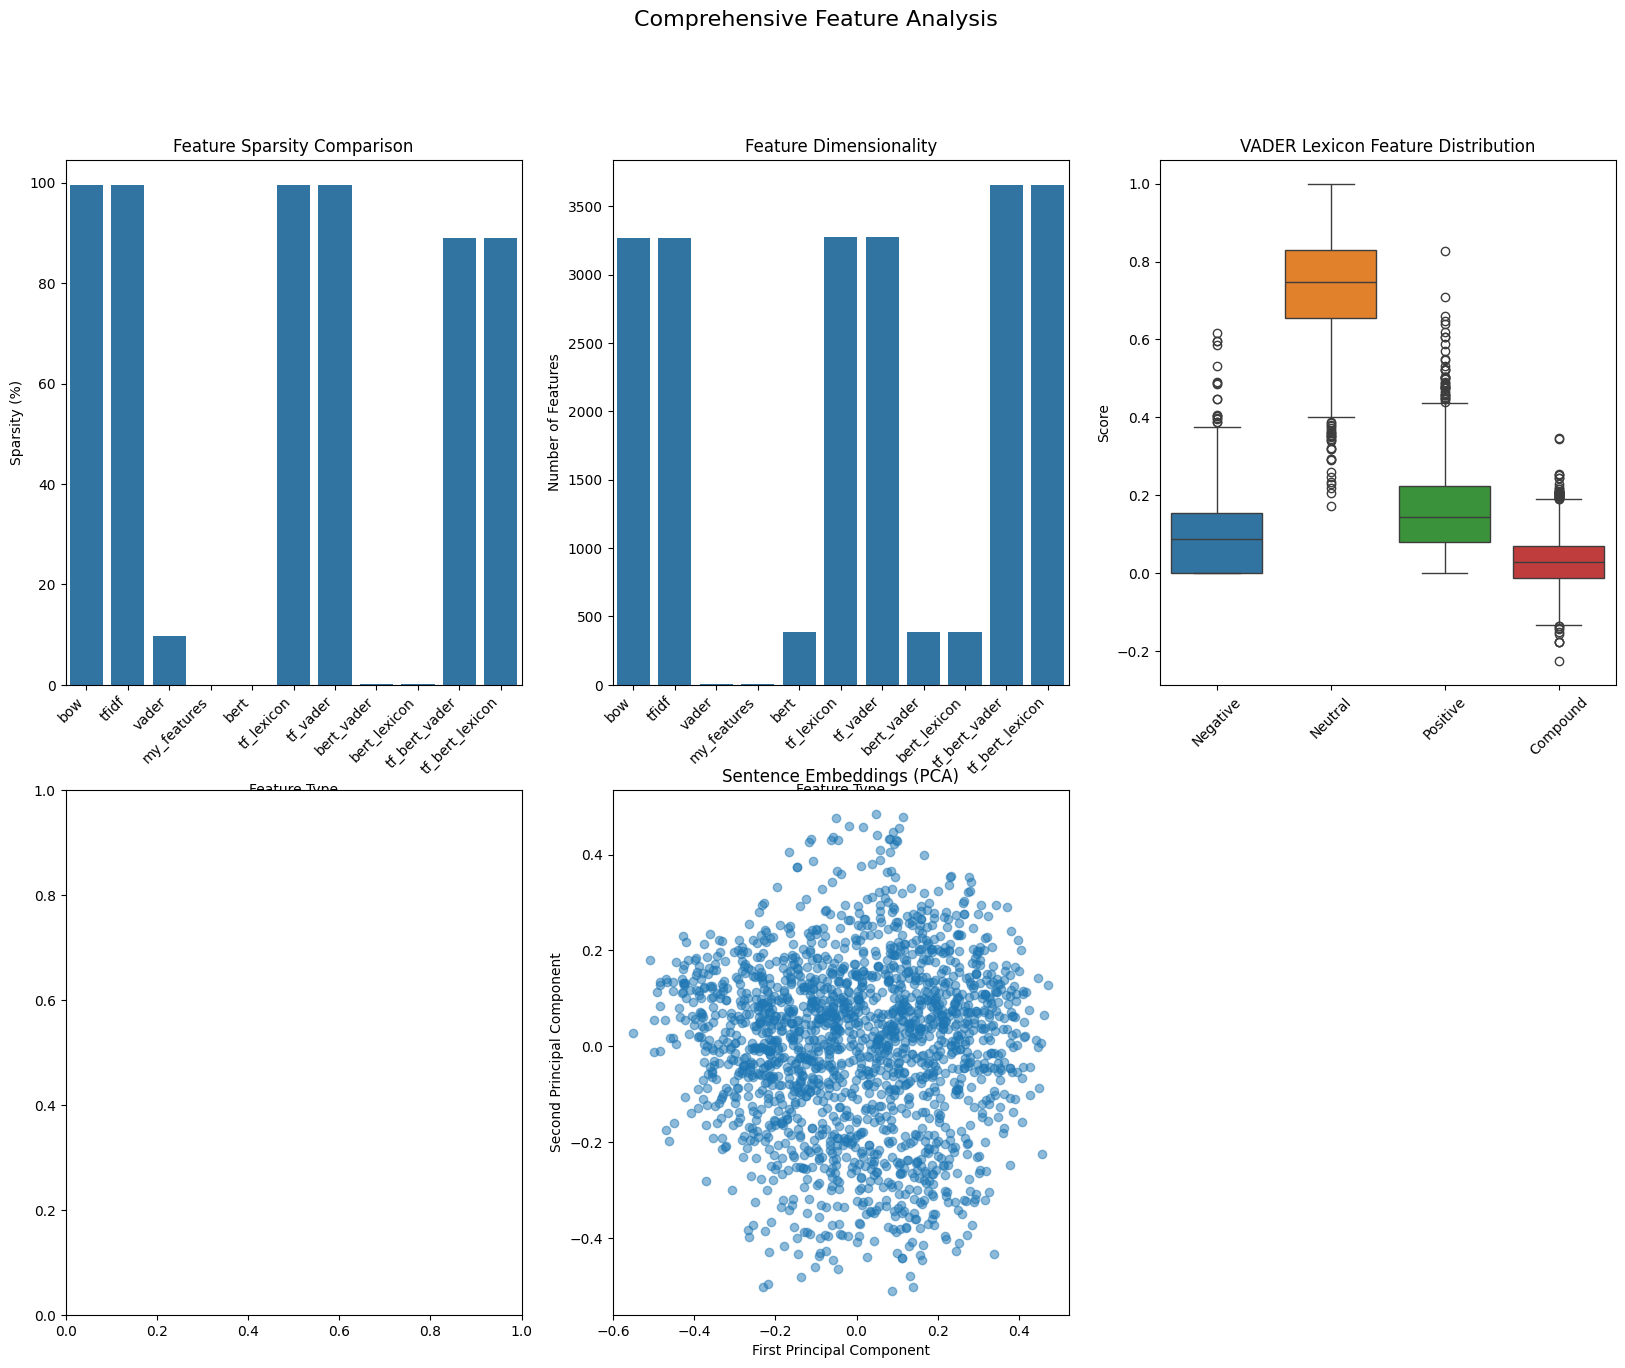

In [28]:

def visualize_features(features):
    """
    Create comprehensive visualizations of feature characteristics.
    
    Parameters:
    features (dict): Dictionary containing feature representations
    """
    # Create a larger figure with subplots
    plt.figure(figsize=(20, 15))
    plt.suptitle('Comprehensive Feature Analysis', fontsize=16)
    
    def calculate_sparsity(feature):
        """Calculate sparsity for different feature types"""
        if isinstance(feature, tuple):
            feature = feature[0]  # For bow, tfidf which return (matrix, vectorizer)
        
        if sp.issparse(feature):
            # Sparse matrix sparsity
            total_elements = feature.shape[0] * feature.shape[1]
            zero_elements = total_elements - feature.nnz
            sparsity = (zero_elements / total_elements) * 100
        elif isinstance(feature, np.ndarray):
            # Numpy array sparsity
            total_elements = feature.size
            zero_elements = np.count_nonzero(feature == 0)
            sparsity = (zero_elements / total_elements) * 100
        else:
            # For complex feature dictionaries
            if 'combined' in feature:
                feature = feature['combined']
                total_elements = feature.shape[0] * feature.shape[1]
                zero_elements = total_elements - feature.nnz
                sparsity = (zero_elements / total_elements) * 100
            else:
                return 0
        
        return sparsity
    
    # 1. Sparsity Comparison
    plt.subplot(2, 3, 1)
    sparsity_values = []
    feature_names = []
    
    for name, feature in features.items():
        try:
            sparsity = calculate_sparsity(feature)
            sparsity_values.append(sparsity)
            feature_names.append(name)
        except:
            pass
    
    sns.barplot(x=feature_names, y=sparsity_values)
    plt.title('Feature Sparsity Comparison')
    plt.xlabel('Feature Type')
    plt.ylabel('Sparsity (%)')
    plt.xticks(rotation=45, ha='right')
    
    # 2. Feature Shapes
    plt.subplot(2, 3, 2)
    shapes = []
    for name, feature in features.items():
        try:
            if isinstance(feature, tuple):
                shapes.append(feature[0].shape[1])
            elif isinstance(feature, np.ndarray):
                shapes.append(feature.shape[1])
            elif isinstance(feature, dict) and 'combined' in feature:
                shapes.append(feature['combined'].shape[1])
            else:
                shapes.append(0)
        except:
            shapes.append(0)
    
    sns.barplot(x=feature_names, y=shapes)
    plt.title('Feature Dimensionality')
    plt.xlabel('Feature Type')
    plt.ylabel('Number of Features')
    plt.xticks(rotation=45, ha='right')
    
    # 3. Distribution of VADER Features
    plt.subplot(2, 3, 3)
    if 'vader' in features and isinstance(features['vader'], np.ndarray):
        vader_features = features['vader']
        vader_columns = ['Negative', 'Neutral', 'Positive', 'Compound']
        sns.boxplot(data=vader_features)
        plt.title('VADER Lexicon Feature Distribution')
        plt.xticks(range(4), vader_columns, rotation=45)
        plt.ylabel('Score')
    
    # 4. Distribution of NRC Features
    plt.subplot(2, 3, 4)
    if 'nrc' in features and isinstance(features['nrc'], np.ndarray):
        nrc_features = features['nrc']
        nrc_emotions = ['anger', 'fear', 'anticipation', 'trust', 
                        'surprise', 'sadness', 'joy', 'disgust', 
                        'positive', 'negative']
        sns.boxplot(data=nrc_features)
        plt.title('NRC Emotion Lexicon Distribution')
        plt.xticks(range(10), nrc_emotions, rotation=90)
        plt.ylabel('Score')
    
    # 5. Embedding Dimensionality Reduction
    plt.subplot(2, 3, 5)
    if 'bert' in features and isinstance(features['bert'], np.ndarray):
        from sklearn.decomposition import PCA
        bert_embeddings = features['bert']
        pca = PCA(n_components=2)
        bert_pca = pca.fit_transform(bert_embeddings)
        plt.scatter(bert_pca[:, 0], bert_pca[:, 1], alpha=0.5)
        plt.title('Sentence Embeddings (PCA)')
        plt.xlabel('First Principal Component')
        plt.ylabel('Second Principal Component')
    
    # Print summary statistics
    print("\n--- Feature Summary Statistics ---")
    for name, feature in features.items():
        try:
            if isinstance(feature, tuple):
                feature_matrix = feature[0]
            elif isinstance(feature, dict) and 'combined' in feature:
                feature_matrix = feature['combined']
            elif isinstance(feature, np.ndarray):
                feature_matrix = feature
            else:
                continue
            
            print(f"\n{name.upper()} Features:")
            if sp.issparse(feature_matrix):
                print(f"Shape: {feature_matrix.shape}")
                print(f"Sparsity: {calculate_sparsity(feature_matrix):.2f}%")
            else:
                print(f"Shape: {feature_matrix.shape}")
                print(f"Mean: {feature_matrix.mean()}")
                print(f"Std Dev: {feature_matrix.std()}")
        except Exception as e:
            print(f"Could not analyze {name}: {e}")
    # NRC Emotion Lexicon Insights
    print("\nNRC Emotion Lexicon Summary:")
    nrc_emotions = ['anger', 'fear', 'anticipation', 'trust', 'surprise', 
                    'sadness', 'joy', 'disgust', 'positive', 'negative']
    nrc_summary = pd.DataFrame(features['nrc'], columns=nrc_emotions)
    print(nrc_summary.describe())
    # Correlation Analysis
    print("\nCorrelation between NRC Emotion Features:")
    nrc_corr = nrc_summary.corr()
    plt.figure(figsize=(10, 8))
    sns.heatmap(nrc_corr, annot=True, cmap='coolwarm', center=0)
    plt.title('Correlation between NRC Emotion Features')
    plt.tight_layout()
    plt.show()
    

# Usage would be:
visualize_features(features)


--- Top Words Correlated with Sentiment ---

Top Positive Sentiment Words:
like: 0.2419
not: 0.2403
nothing: 0.2365
neutral: 0.1977
lately: 0.1884
feel: 0.1795
keep: 0.1673
motion: 0.1595
feeling: 0.1575
disconnected: 0.1541

Top Negative Sentiment Words:
sadness: -0.2029
felt: -0.1915
also: -0.1899
sense: -0.1759
bittersweet: -0.1707
memory: -0.1610
mix: -0.1599
gratitude: -0.1507
childhood: -0.1441
nostalgia: -0.1344


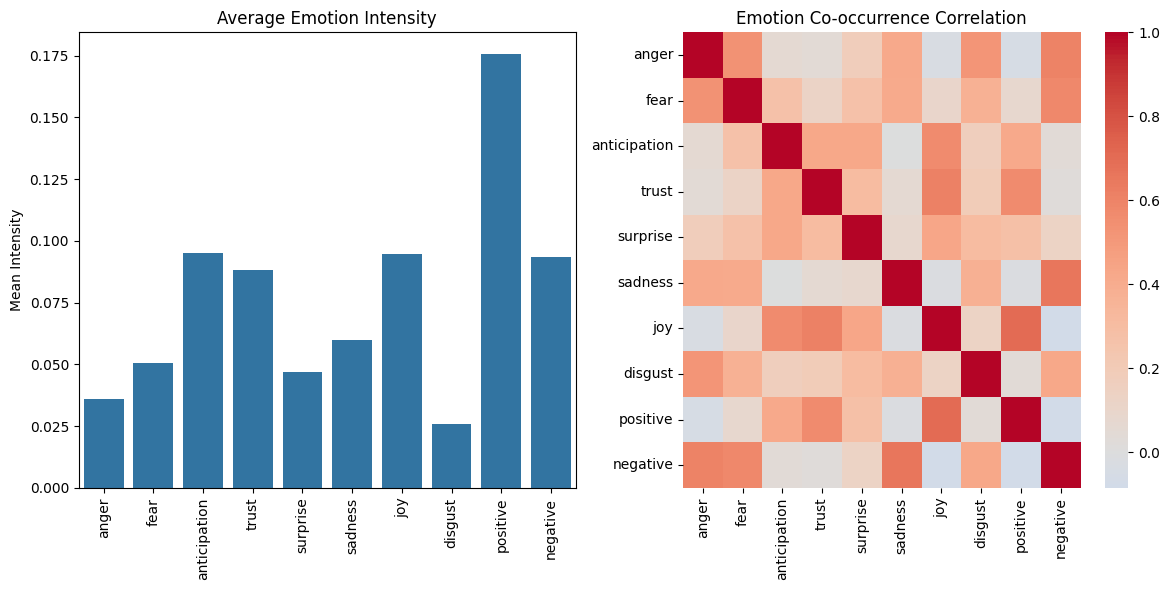

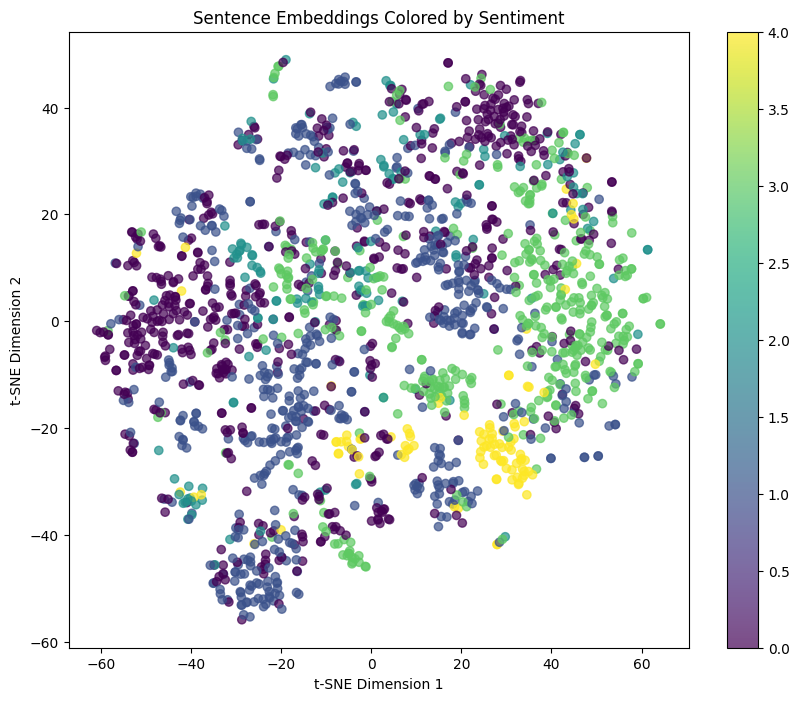

In [ ]:

def advanced_feature_insights(features, df):
    # 1. Top Influential Words in TF-IDF
    tfidf_vectorizer = features['tfidf'][1]
    tfidf_features = features['tfidf'][0]
    
    # Calculate correlation with sentiment
    sentiment_numeric = pd.factorize(df['sentiment'])[0]
    
    feature_names = tfidf_vectorizer.get_feature_names_out()
    word_sentiment_corr = []
    
    for i in range(tfidf_features.shape[1]):
        feature_column = tfidf_features[:, i].toarray().flatten()
        corr, _ = pearsonr(feature_column, sentiment_numeric)
        word_sentiment_corr.append((feature_names[i], corr))
    
    # Sort by absolute correlation
    top_positive_words = sorted(word_sentiment_corr, key=lambda x: x[1], reverse=True)[:10]
    top_negative_words = sorted(word_sentiment_corr, key=lambda x: x[1])[:10]
    
    print("\n--- Top Words Correlated with Sentiment ---")
    print("\nTop Positive Sentiment Words:")
    for word, corr in top_positive_words:
        print(f"{word}: {corr:.4f}")
    
    print("\nTop Negative Sentiment Words:")
    for word, corr in top_negative_words:
        print(f"{word}: {corr:.4f}")
    
    # 2. Emotion Lexicon Depth Analysis
    vader_features = features['vader']
    nrc_features = features['nrc']
    
    # Emotion Intensity Distribution
    plt.figure(figsize=(12, 6))
    
    plt.subplot(1, 2, 1)
    emotion_intensities = nrc_features.mean(axis=0)
    emotion_names = ['anger', 'fear', 'anticipation', 'trust', 'surprise', 
                     'sadness', 'joy', 'disgust', 'positive', 'negative']
    
    sns.barplot(x=emotion_names, y=emotion_intensities)
    plt.title('Average Emotion Intensity')
    plt.xticks(rotation=90)
    plt.ylabel('Mean Intensity')
    
    # Emotion Co-occurrence
    plt.subplot(1, 2, 2)
    emotion_cooccurrence = np.corrcoef(nrc_features.T)
    sns.heatmap(emotion_cooccurrence, 
                xticklabels=emotion_names, 
                yticklabels=emotion_names, 
                cmap='coolwarm', center=0)
    plt.title('Emotion Co-occurrence Correlation')
    
    plt.tight_layout()
    plt.show()
    
    # 3. Embedding Space Analysis
    bert_embeddings = features['bert']
    from sklearn.manifold import TSNE
    
    # Dimensionality Reduction with t-SNE
    tsne = TSNE(n_components=2, random_state=42)
    bert_tsne = tsne.fit_transform(bert_embeddings)
    
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(bert_tsne[:, 0], bert_tsne[:, 1], 
                          c=sentiment_numeric, 
                          cmap='viridis', 
                          alpha=0.7)
    plt.colorbar(scatter)
    plt.title('Sentence Embeddings Colored by Sentiment')
    plt.xlabel('t-SNE Dimension 1')
    plt.ylabel('t-SNE Dimension 2')
    plt.show()

# Call the advanced insights function
advanced_feature_insights(features, df)